In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [18]:
features_df = pd.read_parquet("data/contribution_data/extracted_features.parquet")

In [19]:
features_df.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,emergency,geological,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism
0,2377515,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,-62.976084,...,0,0,0,0,0,0,0,0,0,True
1,2377515,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,-62.956141,...,0,0,0,0,0,0,0,0,0,True
2,6335199,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,-90.207543,...,0,0,0,0,0,1,0,0,0,True
3,5193146,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,-0.898112,...,0,0,0,0,0,0,1,0,0,True
4,3149129,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,-34.881410,...,0,0,0,0,0,0,0,0,0,True


In [27]:
if features_df.columns.__contains__('xzcode'):
    # Split 'xzcode' column into two separate columns 'code' and 'level'
    features_df[['code', 'level']] = pd.json_normalize(features_df['xzcode'])
    features_df.drop('xzcode', axis=1, inplace=True)
features_df.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism,code,level
0,2377515,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,-62.976084,...,0,0,0,0,0,0,0,True,384395826,14
1,2377515,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,-62.956141,...,0,0,0,0,0,0,0,True,384395847,14
2,6335199,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,-90.207543,...,0,0,0,1,0,0,0,True,3209861041,15
3,5193146,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,-0.898112,...,0,0,0,0,1,0,0,True,3576265364,15
4,3149129,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,-34.881410,...,0,0,0,0,0,0,0,True,1391593370,16


In [29]:
features_df.status.unique()

array(['deleted', 'history', 'latest'], dtype=object)

In [30]:
if features_df.columns.__contains__('geometry'):
    features_df.drop('geometry', axis=1, inplace=True)
    
if features_df.columns.__contains__('osm_id'):
    features_df.drop('osm_id', axis=1, inplace=True)
    
features_df.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism,code,level
0,2377515,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,-62.976084,...,0,0,0,0,0,0,0,True,384395826,14
1,2377515,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,-62.956141,...,0,0,0,0,0,0,0,True,384395847,14
2,6335199,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,-90.207543,...,0,0,0,1,0,0,0,True,3209861041,15
3,5193146,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,-0.898112,...,0,0,0,0,1,0,0,True,3576265364,15
4,3149129,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,-34.881410,...,0,0,0,0,0,0,0,True,1391593370,16


In [87]:
features_df.columns = features_df.columns.str.replace(' ', '_', regex=True)
features_df.head()

,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,time_since_last_edit,edit_time_of_day,...,bbox_y_range,centroid_x,centroid_y,country_count,historical_validity,tag_density,change_ratio,changeset_comment_length,source_reliability,vandalism
0,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,53.874167,23,...,0.000566,-63.006063,-84.906174,0,1,0.0,-1.0,0,0,True
1,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,53.874167,23,...,0.000786,-63.023894,-84.905413,0,1,0.0,-1.0,0,0,True
2,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,0.000278,1,...,0.004987,-90.208055,38.524025,1,1,0.0,-1.0,25,0,True
3,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,0.000278,20,...,0.003423,-0.904047,41.657534,1,1,0.0,-1.0,22,0,True
4,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,0.000278,20,...,0.000060,-34.881462,-8.043139,1,1,0.0,-1.0,21,0,True


In [88]:
X = features_df.drop('vandalism', axis=1).copy()
X.head()

,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,time_since_last_edit,edit_time_of_day,...,bbox_x_range,bbox_y_range,centroid_x,centroid_y,country_count,historical_validity,tag_density,change_ratio,changeset_comment_length,source_reliability
0,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,53.874167,23,...,0.020857,0.000566,-63.006063,-84.906174,0,1,0.0,-1.0,0,0
1,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,53.874167,23,...,0.019641,0.000786,-63.023894,-84.905413,0,1,0.0,-1.0,0,0
2,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,0.000278,1,...,0.001586,0.004987,-90.208055,38.524025,1,1,0.0,-1.0,25,0
3,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,0.000278,20,...,0.009811,0.003423,-0.904047,41.657534,1,1,0.0,-1.0,22,0
4,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,0.000278,20,...,0.000097,0.000060,-34.881462,-8.043139,1,1,0.0,-1.0,21,0


In [89]:
y = features_df['vandalism'].copy()
y.head()

0    True
1    True
2    True
3    True
4    True
Name: vandalism, dtype: bool

In [90]:
X_encoded = pd.get_dummies(X, columns=['source_reliability',
                                                'historical_validity',
                                                'country_count',
                                                'population_changed',
                                                'boundary_changed',
                                                'name_changed',
                                                'tags_modified',
                                                'tags_added',
                                                'tags_removed',
                                                'edit_time_of_day',
                                                'geometry_valid',
                                                'editor_used',
                                       'osm_type',
                                       'contribution_type',
                                       'status'])
X_encoded.head()

,user_edit_frequency,area_delta,length_delta,area,length,bounding_box_size,time_since_last_edit,bbox_x_range,bbox_y_range,centroid_x,...,editor_used_osmtools,editor_used_peundemerg.ro-0.1,editor_used_railwayz.info photolines engine,editor_used_reverter;JOSM,editor_used_reverter_plugin,editor_used_rocketdata.io,editor_used_rosemary v0.3.12,editor_used_rosemary v0.4.4,editor_used_simple_revert.py,editor_used_upload.py v. 1
0,32.000000,-597,0,0,0,1.180083e-05,53.874167,0.020857,0.000566,-63.006063,...,False,False,False,False,False,False,False,False,False,False
1,32.000000,-661,0,0,0,1.543374e-05,53.874167,0.019641,0.000786,-63.023894,...,False,False,False,False,False,False,False,False,False,False
2,5.490196,-6351,0,0,0,7.911717e-06,0.000278,0.001586,0.004987,-90.208055,...,False,False,False,False,False,False,False,False,False,False
3,3.762032,-60560,0,0,0,3.357874e-05,0.000278,0.009811,0.003423,-0.904047,...,False,False,False,False,False,False,False,False,False,False
4,3791.000000,-47,0,0,0,5.833380e-09,0.000278,0.000097,0.000060,-34.881462,...,False,False,False,False,False,False,False,False,False,False


In [91]:
y = y.replace(True, 1)
y = y.replace(False, 0)

C:\Users\saise\AppData\Local\Temp\ipykernel_27428\3107921932.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(False, 0)


In [92]:
y.dtype

dtype('int64')

In [93]:
sum(y) / len(y)

0.6621638875411762

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

In [108]:
# Get the shapes of the datasets
shapes = {
    'X_train shape': X_train.shape,
    'X_test shape': X_test.shape,
    'y_train shape': y_train.shape,
    'y_test shape': y_test.shape
}

# Convert shapes to DataFrame for better display
shapes_df = pd.DataFrame(shapes, index=['Number of Samples', 'Number of Features']).T
print(shapes_df)

               Number of Samples  Number of Features
X_train shape             352449                 550
X_test shape              117483                 550
y_train shape             352449              352449
y_test shape              117483              117483


In [95]:
sum(y_train)/len(y_train)

0.6621638875411762

In [96]:
sum(y_test)/len(y_test)

0.6621638875411762

In [97]:
import xgboost as xgb

# Convert the datasets to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify model parameters with both 'aucpr' and 'accuracy'
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': ['aucpr', 'error'],  # 'error' is 1 - accuracy
    'seed': 42
}

# Set up the evaluation set
evals = [(dtest, 'eval')]

# Train the model with early stopping
bst = xgb.train(params, dtrain, num_boost_round=100, evals=evals,
                early_stopping_rounds=15, verbose_eval=True)


[0]	eval-aucpr:0.95205	eval-error:0.21357
[1]	eval-aucpr:0.97028	eval-error:0.16006
[2]	eval-aucpr:0.97898	eval-error:0.12521
[3]	eval-aucpr:0.98072	eval-error:0.11168
[4]	eval-aucpr:0.98310	eval-error:0.09774
[5]	eval-aucpr:0.98413	eval-error:0.09103
[6]	eval-aucpr:0.98530	eval-error:0.08611
[7]	eval-aucpr:0.98621	eval-error:0.08506
[8]	eval-aucpr:0.98701	eval-error:0.08192
[9]	eval-aucpr:0.98742	eval-error:0.08119
[10]	eval-aucpr:0.98777	eval-error:0.08230
[11]	eval-aucpr:0.98803	eval-error:0.08119
[12]	eval-aucpr:0.98821	eval-error:0.07974
[13]	eval-aucpr:0.98842	eval-error:0.07963
[14]	eval-aucpr:0.98902	eval-error:0.07727
[15]	eval-aucpr:0.98935	eval-error:0.07616
[16]	eval-aucpr:0.98964	eval-error:0.07544
[17]	eval-aucpr:0.99031	eval-error:0.07291
[18]	eval-aucpr:0.99074	eval-error:0.07032
[19]	eval-aucpr:0.99082	eval-error:0.06955
[20]	eval-aucpr:0.99095	eval-error:0.06917
[21]	eval-aucpr:0.99126	eval-error:0.06772
[22]	eval-aucpr:0.99143	eval-error:0.06731
[23]	eval-aucpr:0.991

In [98]:
# Make predictions on the test data
y_pred_proba = bst.predict(dtest)  # Get predicted probabilities
y_pred = np.where(y_pred_proba > 0.5, 1, 0)  # Convert probabilities to binary predictions


Statistics:
True Negatives (TN): 39549
False Positives (FP): 141
False Negatives (FN): 292
True Positives (TP): 77501
Accuracy: 0.9963
Precision: 0.9982
Recall: 0.9962
F1 Score: 0.9972


<Figure size 800x600 with 0 Axes>

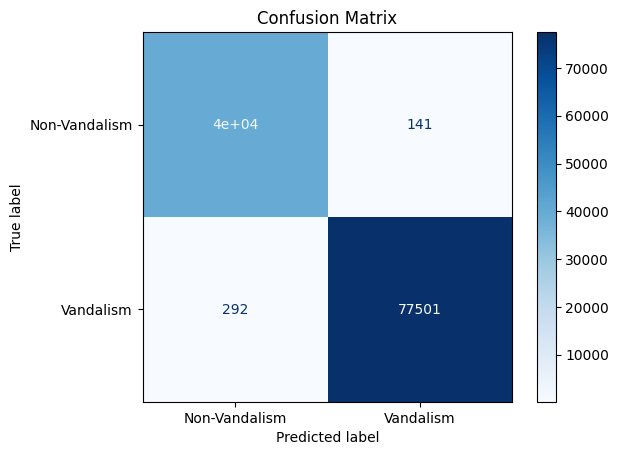

In [103]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate additional statistics
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print statistics
print(f"\nStatistics:")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Vandalism', 'Vandalism']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()